### Building a simple graph and training a simple GNN 

#### Installations

In [ ]:
%pip install -r ../../requirements.txt


#### Imports

In [1]:
import pathlib
import os
import sys
from IPython.display import Image
from py2neo import Graph, Relationship, RelationshipMatcher
parent_path = pathlib.Path(os.getcwd()).parent.absolute()
sys.path.append(str(parent_path))

from utils.general import read_csv, df_to_json, get_year_from_title, remove_year_from_title_str
from utils_draft.movies import insert_movies
from utils_draft.users import insert_ratings
from utils.gnn_simple import GNNEncoder, EdgeDecoder

#### Connecting to the neo4j instance

In [2]:
graph = Graph(
    "bolt://localhost:7687",
    auth=("neo4j", "admin"),
)

#### Storing the movies

##### Simple pre-process of the movies dataframe

In [3]:
movies_df = read_csv("movies")

# split the genres string to a python list
# movies_df["genres"] = movies_df["genres"].map(lambda l: l.split("|"))

# store the movie's year in a separate column
movies_df["year"] = movies_df["title"].map(lambda title: get_year_from_title(title)).astype("string")

# remove the year from the title
movies_df["title"] = movies_df["title"].map(remove_year_from_title_str)

movies_df.head()

Reading from: c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\movies_db\data_small\movies.csv


,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


##### Storing them to neo4j

In [4]:
MOVIES_LIMIT = -1
movies = df_to_json(movies_df)
insert_movies(graph, movies, MOVIES_LIMIT)


#### Storing the users and the ratings

In [5]:
RATINGS_LIMIT = -1
ratings_df = read_csv("ratings")
ratings = df_to_json(ratings_df)
insert_ratings(graph, ratings, RATINGS_LIMIT)

Reading from: c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\movies_db\data_small\ratings.csv


#### Observing the Graph

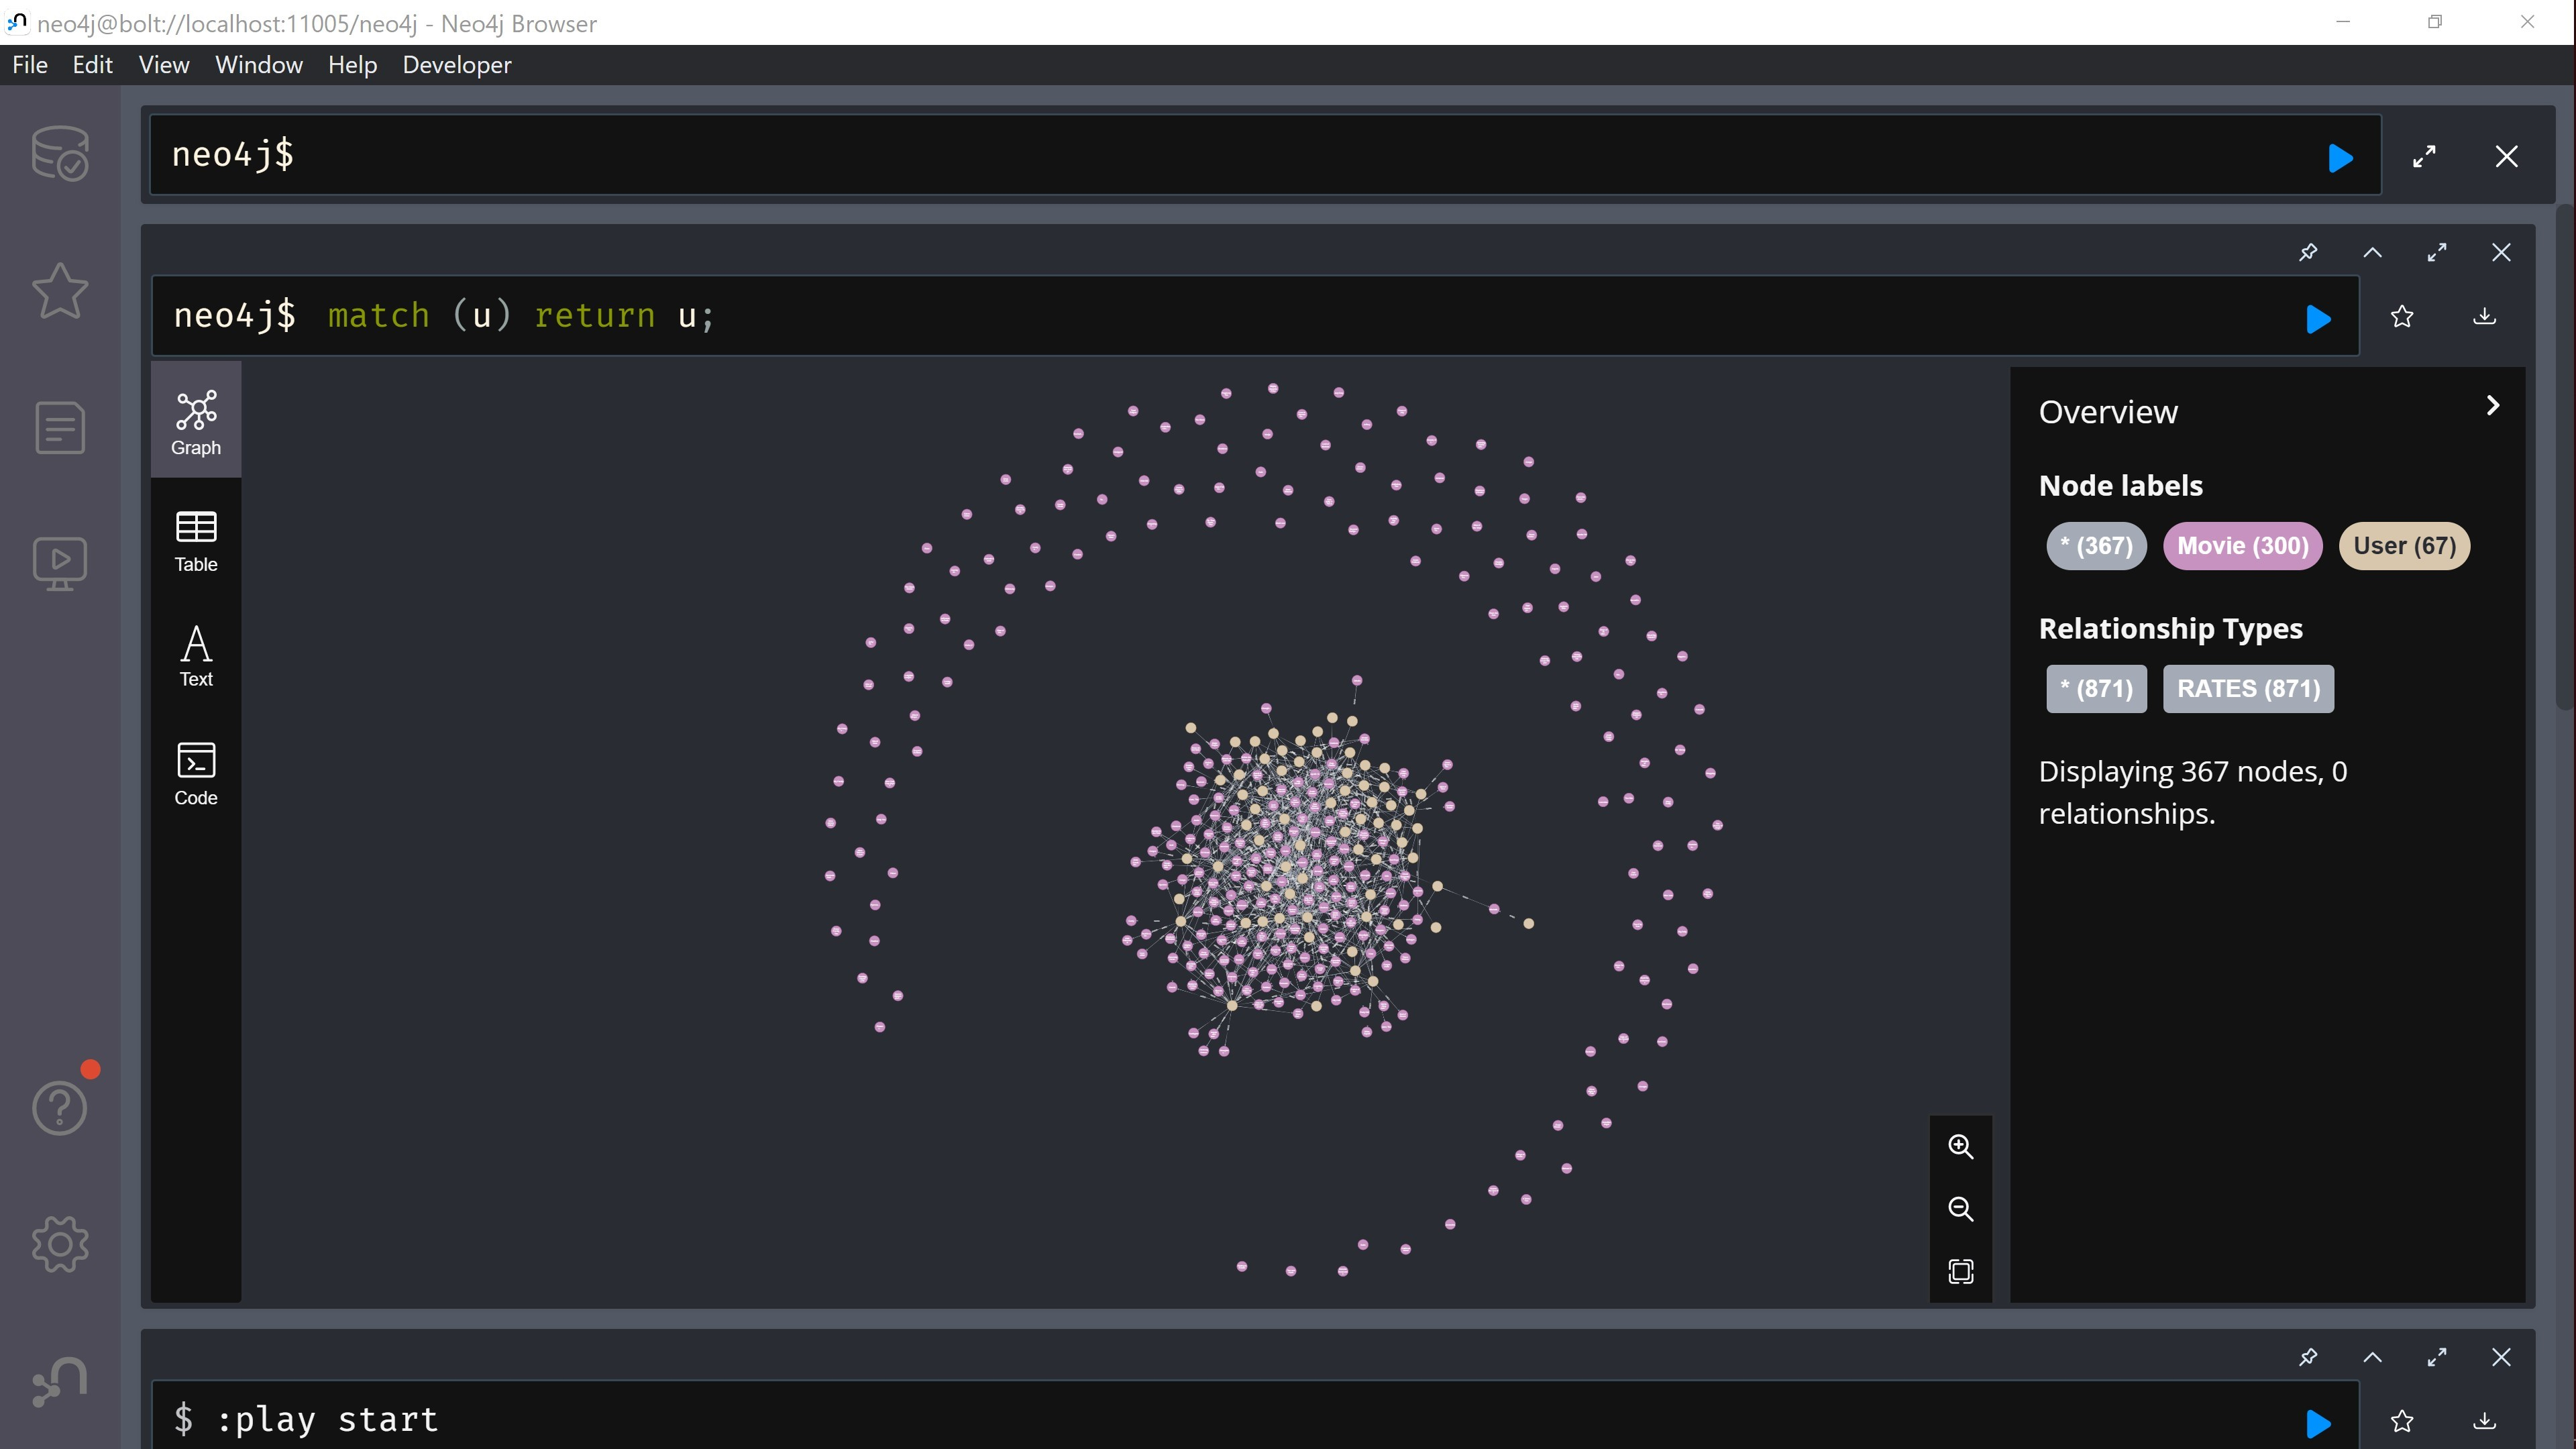

In [ ]:
Image(filename='../images/simple_small_graph.jpg')


#### Trying a simple PyG GNN

##### Imports

In [3]:
import torch
from torch_geometric.data import HeteroData
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from torch_geometric.nn import to_hetero
import torch.nn.functional as F
from utils_draft.pyg import load_node, load_edge, SequenceEncoder, IdentityEncoder, ListEncoder

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


##### Movies nodes

In [5]:
movies_query = """
    MATCH (m: Movie)
    return m.movieId as movieId, m.title as title, m.genres as genres, m.year as year, m["fastrp-embedding"] as fastrp
"""

movies_x, movies_mapping = load_node(
    graph=graph,
    query=movies_query,
    index_col="movieId",
    encoders={
        "title": SequenceEncoder(),
        "genres": ListEncoder(sep="|"),
        # "year": IdentityEncoder(),
        "fastrp": IdentityEncoder(is_list=True),
    }
)


items: dict_items([('title', <utils.pyg.SequenceEncoder object at 0x000002D8F5722AA0>), ('genres', <utils.pyg.ListEncoder object at 0x000002D8F5A9FAF0>), ('fastrp', <utils.pyg.IdentityEncoder object at 0x000002D915E4ABC0>)])


Batches:   0%|          | 0/296 [00:00<?, ?it/s]

In [6]:
movies_x.shape

torch.Size([9460, 532])

##### Users nodes

In [8]:
users_query = """
    MATCH (u:User)
    return u.userId as userId, u.username as username, u["fastrp-embedding"] as fastrp;
"""

users_x, users_mapping = load_node(
    graph=graph,
    query=users_query,
    index_col="userId",
    encoders={
        # "avg_rating": IdentityEncoder(dtype=torch.float16),
        # "ratings": IdentityEncoder(dtype=torch.int64),
        # "username": SequenceEncoder(),
        "fastrp": IdentityEncoder(is_list=True),
    }
)


items: dict_items([('fastrp', <utils.pyg.IdentityEncoder object at 0x000002D919084FD0>)])


In [9]:
users_x.shape

torch.Size([610, 128])

##### Ratings edges

In [10]:
ratings_query = """
    MATCH (u:User)-[r:RATES]-(m:Movie)
    return u.userId as userId, r.rating as rating, r.datetime as datetime, m.movieId as movieId;
"""

edge_index, edge_label = load_edge(
    graph=graph,
    query=ratings_query,
    src_index_col="userId",
    src_mapping=users_mapping,
    dst_index_col="movieId",
    dst_mapping=movies_mapping,
    encoders={
        "rating": IdentityEncoder(dtype=torch.long),
        # "datetime": IdentityEncoder(dtype=torch.long),
    }
)

##### Building the dataset

In [11]:
data = HeteroData()

data["user"].x = users_x
data["movie"].x = movies_x

data["user", "reviews", "movie"].edge_index = edge_index
data["user", "reviews", "movie"].edge_label = edge_label
data.to(device, non_blocking=True)
print(data)

HeteroData(
  user={ x=[610, 128] },
  movie={ x=[9460, 532] },
  (user, reviews, movie)={
    edge_index=[2, 96150],
    edge_label=[96150]
  }
)


In [12]:
data = ToUndirected()(data)
del data["movie", "rev_reviews", "user"].edge_label

transform = RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    neg_sampling_ratio=0.0,
    edge_types=[("user", "reviews", "movie")],
    rev_edge_types=[("movie", "rev_reviews", "user")],
)
train_data, val_data, test_data = transform(data)

##### Balancing the reviews

In [13]:
torch.bincount(edge_label)

tensor([ 1314,  4425, 12501, 31547, 33742, 12621])

In [14]:
# We have an unbalanced dataset with many labels for rating 3 and 4, and very
# few for 0 and 1. Therefore we use a weighted MSE loss.

weight = torch.bincount(train_data['user', 'movie'].edge_label)
weight = weight.max() / weight

def weighted_mse_loss(pred, target, weight=None):
    weight = 1. if weight is None else weight[target].to(pred.dtype)
    return (weight * (pred - target.to(pred.dtype)).pow(2)).mean()

##### Training

In [15]:
from torch.nn import Linear, LazyLinear
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv, TransformerConv, GraphConv

layers = {
    "SAGE": SAGEConv,
    "GAT": GATv2Conv,
    "GCN": GCNConv,
    "Transformer": TransformerConv,
    "GraphConv": GraphConv,
}

class GNNEncoder(torch.nn.Module):
    def __init__(self, layer_name="SAGE", num_layers=4, in_channels=-1, hidden_channels=32, out_channels=32, dropout=0.1, skip_connections=True):
        assert num_layers>4
        super().__init__()
        self.dropout = dropout
        self.num_layers = num_layers
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.dropout = dropout
        self.skip_connections = skip_connections
        self.layer = layers.get(layer_name) or SAGEConv
        self.convs = torch.nn.ModuleList()

        self.convs.append(self.layer(self.in_channels, self.hidden_channels))
        for _ in range(self.num_layers-2):
            self.convs.append(self.layer(self.hidden_channels, self.hidden_channels))
        self.convs.append(self.layer(self.hidden_channels, self.out_channels))

    def forward(self, x, edge_index):
        prev_x = None
        for i in range(len(self.convs)-1):
            prev_x = x
            x = self.convs[i](x, edge_index)
            if i>0 and self.skip_connections:
                x = x + prev_x
            x = x.relu()
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x

class EdgeDecoder(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers):
        assert num_layers>2
        super().__init__()
        self.num_layers = num_layers
        self.hidden_channels = hidden_channels
        self.layers = torch.nn.ModuleList()

        self.layers.append(LazyLinear(self.hidden_channels))
        for i in range(self.num_layers-2):
            self.layers.append(Linear(self.hidden_channels, self.hidden_channels))
        self.layers.append(Linear(self.hidden_channels, 1))

    def forward(self, z_dict, edge_label_index):
        row, col = edge_label_index
        z = torch.cat([z_dict['user'][row], z_dict['movie'][col]], dim=-1)
        for i in range(self.num_layers-1):
            z = self.layers[i](z).relu()
        z = self.layers[self.num_layers-1](z)
        return z.view(-1)

class Model(torch.nn.Module):
    def __init__(self, in_channels=-1, hidden_channels=32, out_channels=32, encoder_num_layers=4, decoder_num_layers=4, layer_name="GCN"):
        super().__init__()
        self.encoder = GNNEncoder(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=out_channels,
            layer_name=layer_name,
            num_layers=encoder_num_layers, 
        )
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.encoder = to_hetero(self.encoder, data.metadata(), aggr='sum')
        self.decoder = EdgeDecoder(hidden_channels, num_layers=decoder_num_layers)

    def forward(self, x_dict, edge_index_dict, edge_label_index):
        z_dict = self.encoder(x_dict, edge_index_dict)
        return self.decoder(z_dict, edge_label_index)

In [16]:
def train_test(model, optimizer, epochs):
    def train():
        model.train()
        optimizer.zero_grad()
        pred = model(train_data.collect('x'), train_data.edge_index_dict,
                    train_data['user', 'movie'].edge_label_index)
        target = train_data['user', 'movie'].edge_label
        print(pred)
        loss = weighted_mse_loss(pred, target, weight)
        loss.backward()
        optimizer.step()
        return float(loss)

    @torch.no_grad()
    def test(data):
        model.eval()
        pred = model(data.collect('x'), data.edge_index_dict,
                    data['user', 'movie'].edge_label_index)
        pred = pred.clamp(min=0, max=5)
        target = data['user', 'movie'].edge_label.float()
        rmse = F.mse_loss(pred, target).sqrt()
        return float(rmse)
    losses = []

    for epoch in range(1, epochs):
        loss = train()
        train_rmse = test(train_data)
        val_rmse = test(val_data)
        test_rmse = test(test_data)
        losses.append((loss, train_rmse, val_rmse, test_rmse))
        # if not epochs%epoch:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_rmse:.4f}, '
                f'Val: {val_rmse:.4f}, Test: {test_rmse:.4f}')
    return losses

In [17]:
model = Model(hidden_channels=32, encoder_num_layers=8, decoder_num_layers=5, layer_name="GAT").to(device)
with torch.no_grad():
    model.encoder(train_data.collect('x'), train_data.edge_index_dict)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss__ = train_test(model, optimizer, epochs=50)

c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\environ\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


tensor([0.0956, 0.0954, 0.0955,  ..., 0.0960, 0.0957, 0.0958],
       grad_fn=<ViewBackward0>)
Epoch: 001, Loss: 18.3359, Train: 3.3509, Val: 3.3460, Test: 3.3332
tensor([0.1842, 0.1826, 0.1837,  ..., 0.1836, 0.1826, 0.1851],
       grad_fn=<ViewBackward0>)
Epoch: 002, Loss: 17.4541, Train: 2.9942, Val: 3.0012, Test: 2.9753
tensor([0.5493, 0.5469, 0.5675,  ..., 0.5565, 0.5705, 0.5675],
       grad_fn=<ViewBackward0>)
Epoch: 003, Loss: 14.1167, Train: 1.4784, Val: 1.5690, Test: 1.4924
tensor([2.4613, 2.3376, 2.4258,  ..., 2.3230, 2.4442, 2.4484],
       grad_fn=<ViewBackward0>)
Epoch: 004, Loss: 6.1992, Train: 1.9754, Val: 1.9802, Test: 1.9929
tensor([ 9.9122,  9.5048,  9.4299,  ...,  9.4019, 10.3683,  9.0008],
       grad_fn=<ViewBackward0>)
Epoch: 005, Loss: 113.3936, Train: 1.1106, Val: 1.1556, Test: 1.1242
tensor([3.0738, 3.3584, 3.4032,  ..., 3.2441, 3.3946, 3.3492],
       grad_fn=<ViewBackward0>)
Epoch: 006, Loss: 7.5075, Train: 2.3709, Val: 2.3409, Test: 2.3343
tensor([1.3577, 1

In [97]:
losses = dict()
for layer_name in ["SAGE", "GAT"]:
    model = Model(hidden_channels=32, encoder_num_layers=8, decoder_num_layers=5, layer_name=layer_name).to(device)
    # Due to lazy initialization, we need to run one model step so the number
    # of parameters can be inferred:
    with torch.no_grad():
        model.encoder(train_data.collect('x'), train_data.edge_index_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    losses[layer_name] = train_test(model, optimizer, epochs=500)

c:\Users\GiannisAthanasiou\Desktop\diploma\repo\diploma\environ\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch: 001, Loss: 17.8429, Train: 3.3175, Val: 3.3135, Test: 3.3220
Epoch: 002, Loss: 17.1020, Train: 3.0219, Val: 3.0197, Test: 3.0292
Epoch: 003, Loss: 14.3397, Train: 1.1759, Val: 1.1904, Test: 1.2389
Epoch: 004, Loss: 6.5350, Train: 1.5571, Val: 1.5470, Test: 1.5570
Epoch: 005, Loss: 6.3214, Train: 1.1657, Val: 1.1874, Test: 1.1802
Epoch: 006, Loss: 6.4906, Train: 1.8110, Val: 1.8208, Test: 1.8701
Epoch: 007, Loss: 6.8629, Train: 1.5498, Val: 1.5188, Test: 1.5784
Epoch: 008, Loss: 6.2777, Train: 1.0894, Val: 1.0930, Test: 1.1123
Epoch: 009, Loss: 7.8130, Train: 1.6972, Val: 1.6995, Test: 1.7213
Epoch: 010, Loss: 6.4751, Train: 1.9835, Val: 2.0570, Test: 2.0354
Epoch: 011, Loss: 7.5711, Train: 1.8762, Val: 1.8595, Test: 1.8811
Epoch: 012, Loss: 6.9997, Train: 1.3366, Val: 1.3459, Test: 1.4009
Epoch: 013, Loss: 6.0856, Train: 1.0929, Val: 1.0856, Test: 1.0964
Epoch: 014, Loss: 7.5625, Train: 1.2993, Val: 1.3060, Test: 1.2867
Epoch: 015, Loss: 6.1386, Train: 1.6852, Val: 1.7000, Test:

In [117]:
from matplotlib import pyplot as plt
def plot_loss_by_index(index, losses):
    for type, values in losses.items():
        plt.plot([val[index] for val in values], label=type)
    plt.rcParams["figure.figsize"] = (30,30)
    plt.ylim(0, 6)
    plt.legend()
    plt.show()

def plot_loss(losses):
    plot_loss_by_index(0, losses)

def plot_train(losses):
    plot_loss_by_index(1, losses)

def plot_val(losses):
    plot_loss_by_index(2, losses)

def plot_test(losses):
    plot_loss_by_index(3, losses)

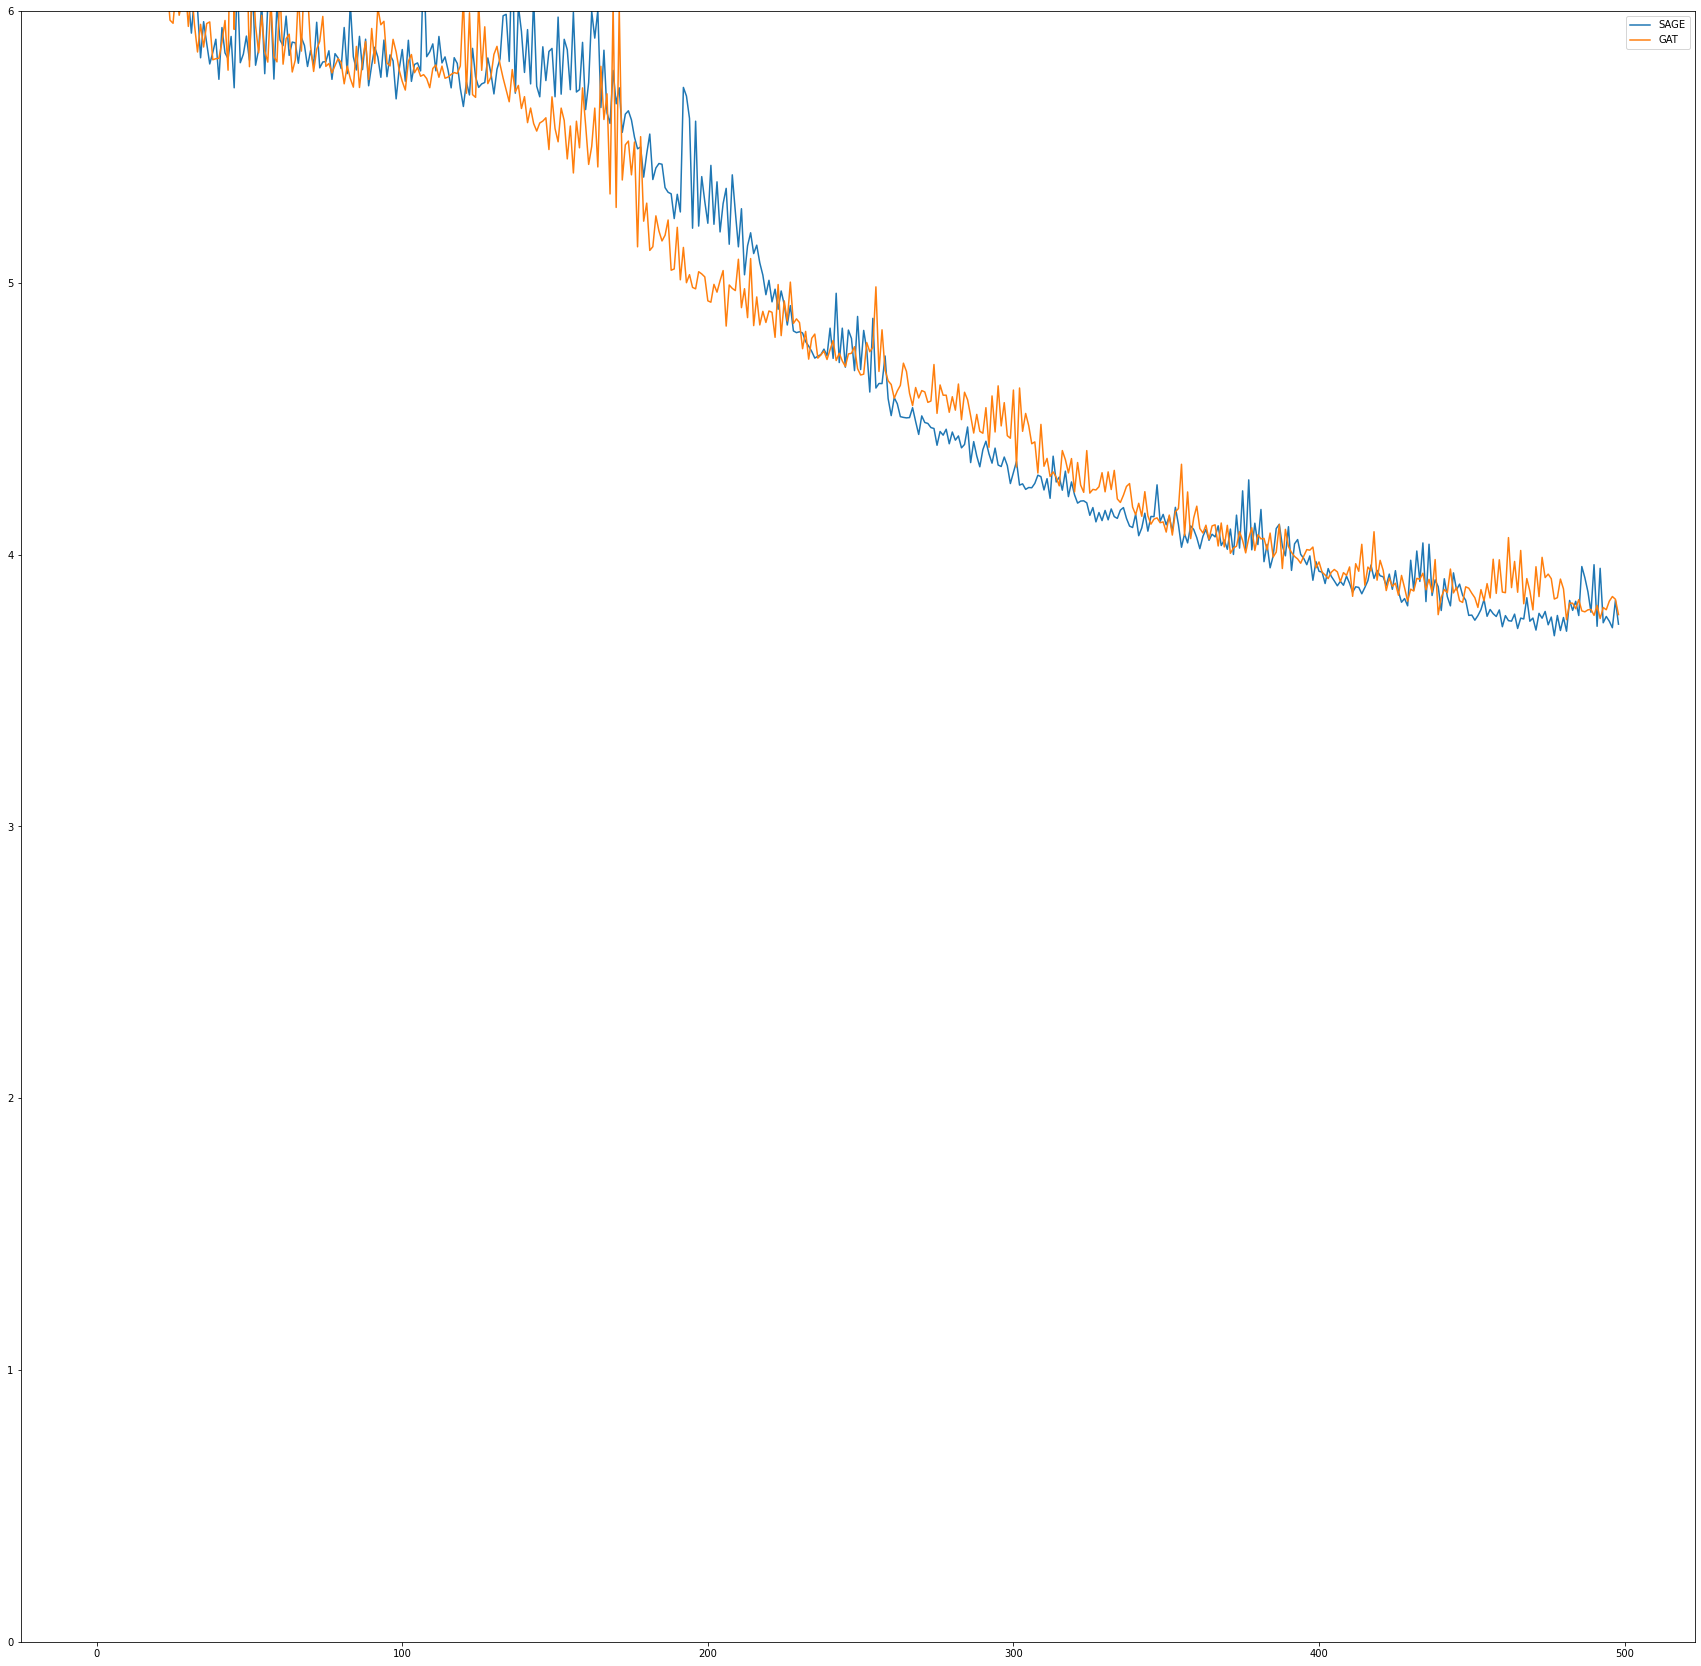

In [120]:
plot_loss(losses)

In [122]:
losses = dict()
for layer_name in ["SAGE", "GAT"]:
    model = Model(hidden_channels=32, encoder_num_layers=8, decoder_num_layers=5, layer_name="GAT").to(device)
    # Due to lazy initialization, we need to run one model step so the number
    # of parameters can be inferred:
    with torch.no_grad():
        model.encoder(train_data.collect('x'), train_data.edge_index_dict)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    losses[layer_name] = train_test(model, optimizer, epochs=1000)

Epoch: 001, Loss: 18.4547, Train: 3.3929, Val: 3.3889, Test: 3.3968
Epoch: 002, Loss: 17.8808, Train: 3.1312, Val: 3.1316, Test: 3.1342
Epoch: 003, Loss: 15.2802, Train: 1.8210, Val: 1.8311, Test: 1.8586
Epoch: 004, Loss: 6.9987, Train: 1.9774, Val: 1.9495, Test: 1.9655
Epoch: 005, Loss: 101.4355, Train: 1.1055, Val: 1.1447, Test: 1.1444
Epoch: 006, Loss: 6.9092, Train: 2.3849, Val: 2.3916, Test: 2.3925
Epoch: 007, Loss: 9.4554, Train: 2.9304, Val: 2.9344, Test: 2.9423
Epoch: 008, Loss: 13.4847, Train: 3.1459, Val: 3.1460, Test: 3.1481
Epoch: 009, Loss: 15.3904, Train: 3.2423, Val: 3.2373, Test: 3.2448
Epoch: 010, Loss: 16.3139, Train: 3.2777, Val: 3.2743, Test: 3.2822
Epoch: 011, Loss: 16.6962, Train: 3.2899, Val: 3.2859, Test: 3.2943
Epoch: 012, Loss: 16.8280, Train: 3.2879, Val: 3.2835, Test: 3.2921
Epoch: 013, Loss: 16.8016, Train: 3.2768, Val: 3.2725, Test: 3.2809
Epoch: 014, Loss: 16.6848, Train: 3.2599, Val: 3.2564, Test: 3.2642
Epoch: 015, Loss: 16.5232, Train: 3.2368, Val: 3.2

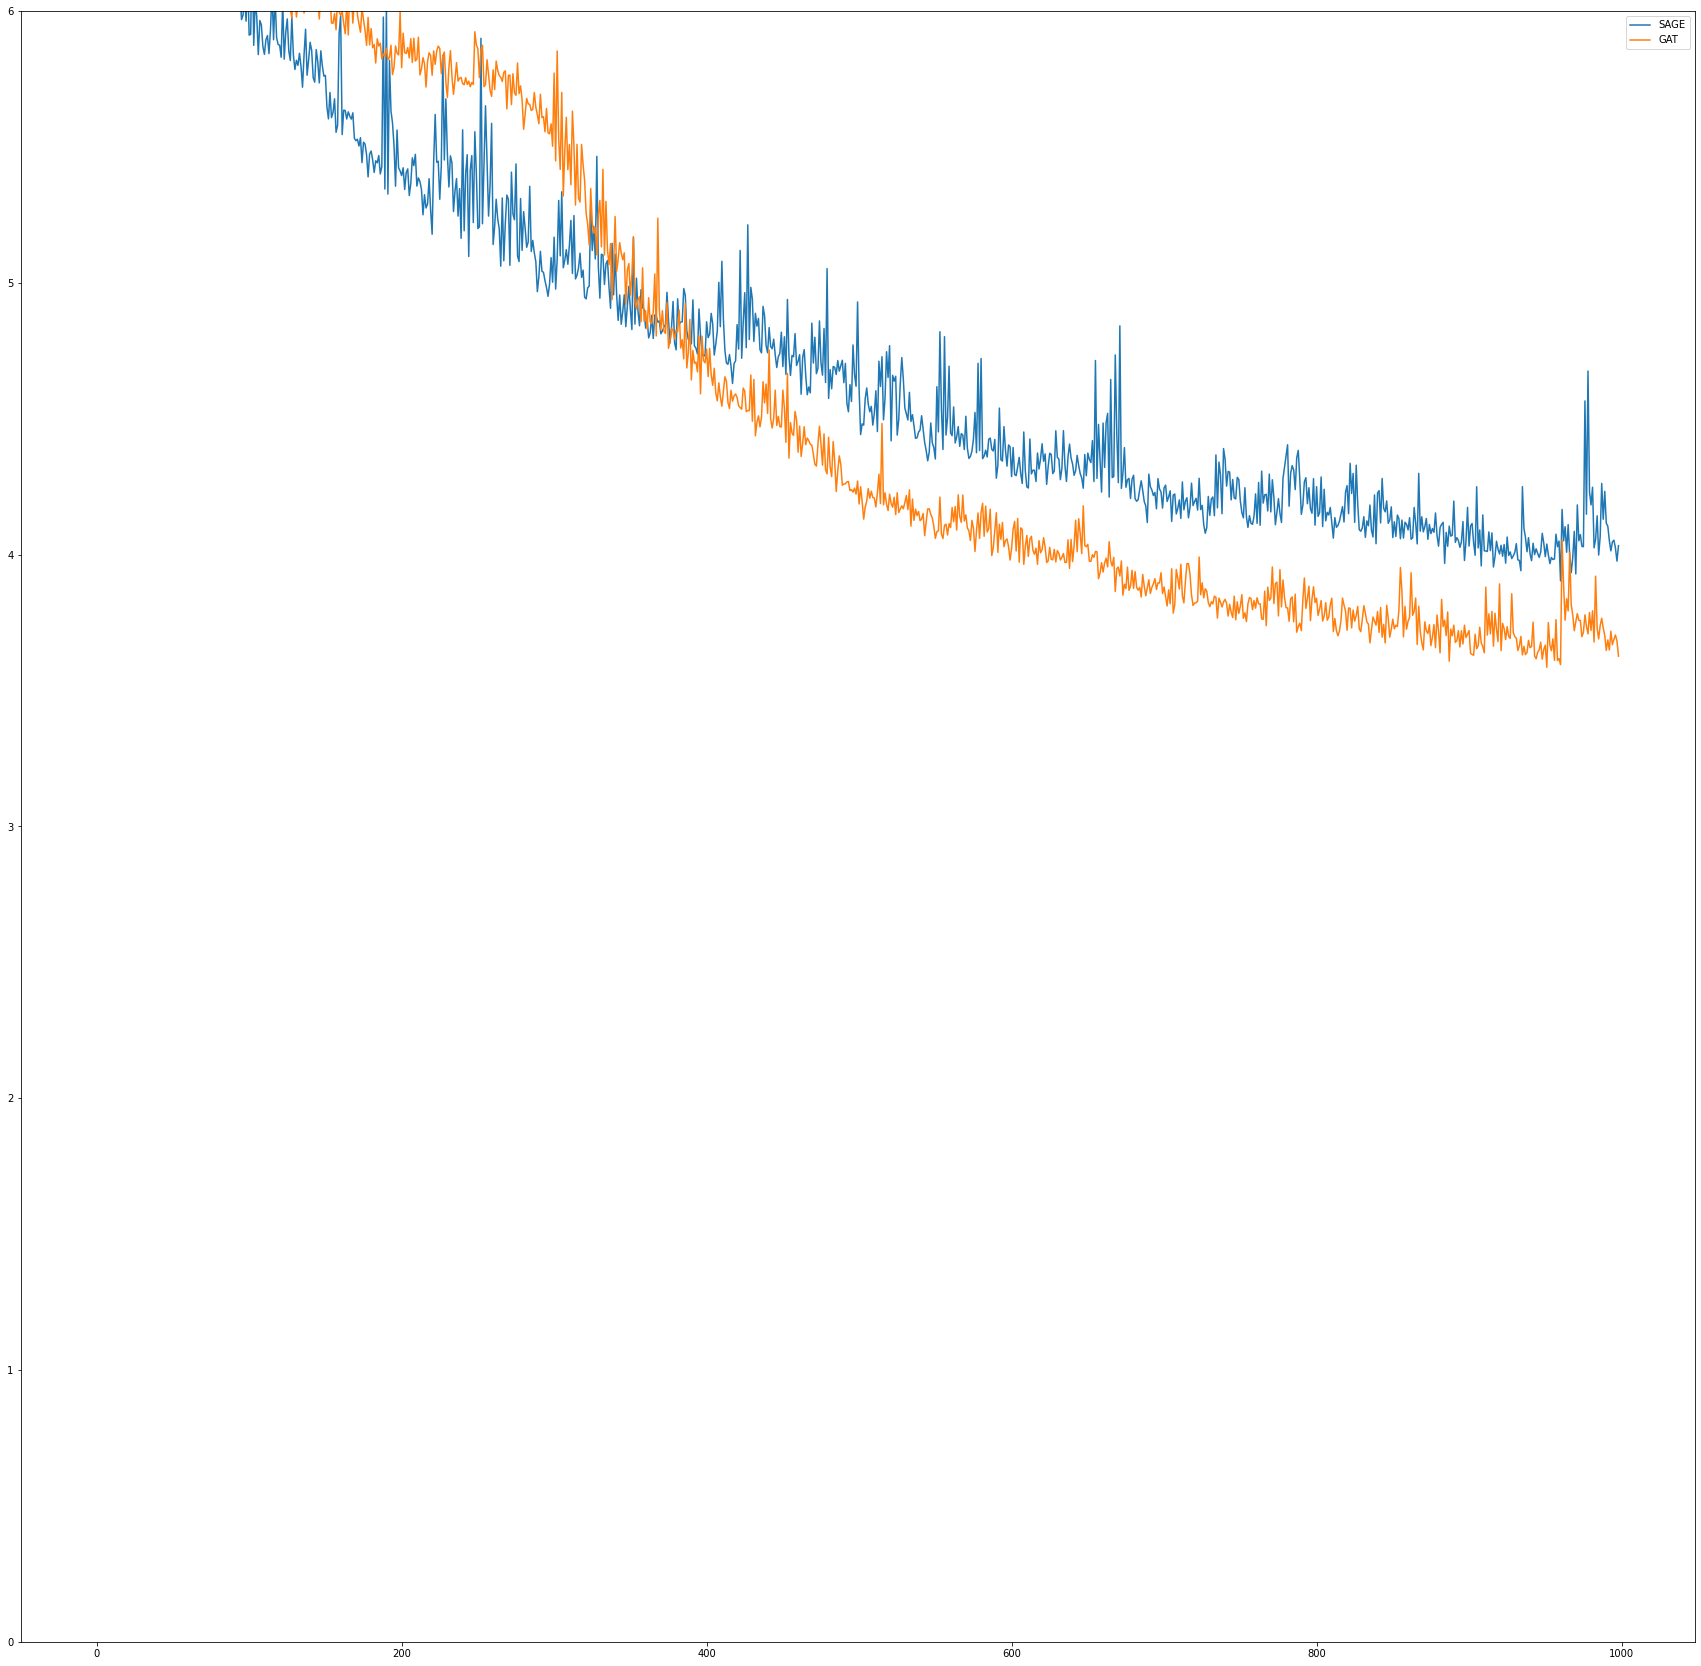

In [123]:
plot_loss(losses)

##### Examining the predictions

In [ ]:
# https://towardsdatascience.com/integrate-neo4j-with-pytorch-geometric-to-create-recommendations-21b0b7bc9aa

num_movies = len(movies_mapping)
num_users = len(users_mapping)

reverse_movie_mapping = dict(zip(movies_mapping.values(),movies_mapping.keys()))
reverse_user_mapping = dict(zip(users_mapping.values(),users_mapping.keys()))

results = []

for user_id in range(0,num_users): 

    row = torch.tensor([user_id] * num_movies)
    col = torch.arange(num_movies)
    edge_label_index = torch.stack([row, col], dim=0)

    pred = model(data.x_dict, data.edge_index_dict,
                 edge_label_index)
    pred = pred.clamp(min=0, max=5)

    user_neo4j_id = reverse_user_mapping[user_id]

    mask = (pred == 5).nonzero(as_tuple=True)

    predictions = [reverse_movie_mapping[el] for el in  mask[0].tolist()[:20]]
    results.append({'user': user_neo4j_id, 'movies': predictions})

In [ ]:
def get_user_suggestions(userId: int):
    movies_ids = []
    movies = []
    for sugg in results:
        if sugg["user"] == userId:
            movies_ids = sugg["movies"]
            break
    for movie_id in movies_ids:
        movie = graph.nodes.match("Movie", movieId=movie_id).first()
        if movie:
            movies.append(movie)
    return movies

def get_user_reviews(userId: int):
    movies_ids = []
    movies = []
    relationship_matcher = RelationshipMatcher(graph)
    RATES = Relationship.type("RATES")
    user = graph.nodes.match("User", userId=userId).first()
    if user:
        reviews = list(relationship_matcher.match([user], r_type=RATES))
        movies_ids = map(lambda review: review.end_node["movieId"], reviews)
        for movie_id in movies_ids:
            movie = graph.nodes.match("Movie", movieId=movie_id).first()
            if movie:
                movies.append(movie)
        return movies
    return f"User {userId} not found"

In [ ]:
print(get_user_reviews(1))
print(get_user_suggestions(1))

[Node('Movie', genres='Drama', movieId=7937, title='Silence, The (Tystnaden)', year='1963'), Node('Movie', genres='Comedy|Drama|Romance', movieId=32591, title='Look at Me (Comme une image)', year='2004'), Node('Movie', genres='Drama|Romance', movieId=31956, title='5x2', year='2004'), Node('Movie', genres='Drama|Mystery|Romance|War', movieId=27721, title='Very Long Engagement, A (Un long dimanche de fiançailles)', year='2004'), Node('Movie', genres='Drama|Fantasy|Romance|Sci-Fi', movieId=27266, title='2046', year='2004'), Node('Movie', genres='Action|Comedy', movieId=27193, title='Taxi 2', year='2000'), Node('Movie', genres='Drama|Thriller', movieId=8973, title='Bad Education (La mala educación)', year='2004'), Node('Movie', genres='Adventure|Drama', movieId=8873, title='Motorcycle Diaries, The (Diarios de motocicleta)', year='2004'), Node('Movie', genres='Drama', movieId=8786, title='Port of Shadows (Quai des brumes)', year='1938'), Node('Movie', genres='Drama', movieId=8729, title='Sw